

- Автор: Гущина Вера
- Дата: 21 августа 2025

## Цели и задачи проекта

<font color='#777778'> Необходимо провести предобрабоку даных и провкрить гипотезу, что "Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо".</font>

## Описание данных

<font color='#777778'>Для анализа представлен файл yandex_knigi_data.csv, содержащий данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности.</font>


## Содержимое проекта

<font color='#777778'> 

    
- Загрузка данных.
    
- Проверка наличия дубликатов в идентификаторах пользователей.
    
- Сравнение размеров групп, их статистики и распределение.
    
- Проверка гипотезы.
    
- Выводы и рекомендации.</font>

---

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from math import ceil
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [2]:
# загрузим данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv
df_knigi=pd.read_csv('/datasets/yandex_knigi_data.csv')

In [3]:
# выгрузим информацию о датафрейме
display(df_knigi.head(5))
df_knigi.info()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


В данных отсутствуют пропуски. Типы данных определены корректно.

In [4]:
# удалим столбец без названия
del df_knigi['Unnamed: 0']

In [5]:
# проверим данные на наличие полных дубликатов
full_duplicates = df_knigi.duplicated()
num_full_duplicates = full_duplicates.sum()
print(f'Количество явных дубликатов: {num_full_duplicates}')

Количество явных дубликатов: 0


In [6]:
# проверим данные на наличие дубликатов по puid
duplicates = df_knigi['puid'].duplicated()
num_duplicates = duplicates.sum()
percent = round(num_duplicates/len(df_knigi)*100,2)
print(f'Количество дубликатов по puid: {num_duplicates}, что составляет {percent}%')

Количество дубликатов по puid: 244, что составляет 2.78%


In [7]:
# удалим дубликаты
df_unique=df_knigi.drop_duplicates(subset=['puid'],keep='first')

In [8]:
# проверим пересечение пользователей в группах по идентификатору
a = df_unique[df_unique['city'] == 'Москва']['puid']
b = df_unique[df_unique['city'] == 'Санкт-Петербург']['puid']

intersection = list(set(a) & set(b))
count = len(set(a) & set(b))
print(intersection) 
print (f'Количество пользователей, включенных в обе группы: {count}')

[]
Количество пользователей, включенных в обе группы: 0


In [9]:
# посчитаем сумму уникальных пользователей по каждой тестовой группе
group_spb=df_unique[df_unique['city']=='Санкт-Петербург']['puid'].nunique()
group_moscow=df_unique[df_unique['city']=='Москва']['puid'].nunique()

# расчитаем процентную разницу
p=(group_spb-group_moscow)/group_spb*100

print (f'Количество пользователей в Санкт-Петербурге: {group_spb}')
print (f'Количество пользователей в Москве: {group_moscow}')
print(f"Процентная разница в количестве пользователей в Санкт-Петербурге и Москве: {round(float(p),2)}%")


Количество пользователей в Санкт-Петербурге: 2306
Количество пользователей в Москве: 6234
Процентная разница в количестве пользователей в Санкт-Петербурге и Москве: -170.34%


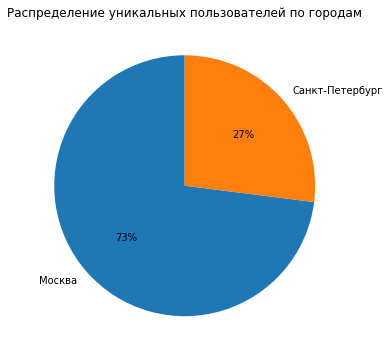

In [10]:
# построим круговую диаграмму для визуализауции соотношения количества пользователей по городам
df_city_group = (
    df_unique
    .groupby(['city'])
    .agg({
        'puid': 'nunique',
    })
    .reset_index()
)

plt.figure(figsize=(6,6))
plt.pie(
    df_city_group['puid'], 
    labels=df_city_group['city'], 
    autopct='%1.0f%%', 
    startangle=90
)
plt.title('Распределение уникальных пользователей по городам')
plt.show()

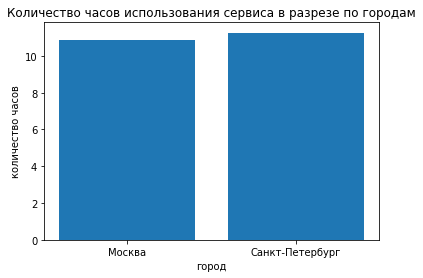

,city,hours
0,Москва,10.881092
1,Санкт-Петербург,11.264433


In [11]:
# посчитаем среднее количество часов пользования сервисом и построим гистограмму
df_city_group_hours = (
    df_unique
    .groupby(['city'])
    .agg({
        'hours': 'mean',
    })
    .reset_index()
)

x = df_city_group_hours['city']
y = df_city_group_hours['hours']
             
plt.bar(x, y)
plt.xlabel('город')
plt.ylabel('количество часов')
plt.title('Количество часов использования сервиса в разрезе по городам')
plt.show()

display(df_city_group_hours)

Среднее количество часов пользования серфисом в Санкт-Петербурге выше, чем в Москве.

По итогу анализа данных установлено, что группы для проведения А/В тестирования распределены неравномено (27% Санкт-Петербург, 73% Москва), при этом среднее количество часов использования сервиса в Санкт-Петербурге выше, чем в Москве (11.26 против 10.88). Расчет данной метрики необходим для проверки гипотезы теста. Учитывая, что численная разница в группах большая (около 170%) для проверки выберем тест Уэлча, позволяющий проводить стат.тест при различающихся выборках.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [12]:
# разделим выборки по городам
spb = df_unique[df_unique['city'] == 'Санкт-Петербург']['hours']
moscow = df_unique[df_unique['city'] == 'Москва']['hours']

# используем односторонний t-тест Уэлча, так как размеры выборок различные: 

t_stat, p_value_welch_ttest= ttest_ind(spb, moscow, 
                                      equal_var=False, 
                                      alternative= 'greater')

# Уровень значимости
alpha = 0.05

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: недостаточно оснований отвергнуть H0. Нет статистически значимого превосходства СПб над Москвой')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: Среднее время активности в СПб статистически больше, чем в Москве')


p-value теста Уэлча =0.34
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: недостаточно оснований отвергнуть H0. Нет статистически значимого превосходства СПб над Москвой


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



------

Для проверки гипотезы в связи с тем, что размеры выборок значительно отличаются (Москва - 73%, Санкт-Петербург 27%) был выбран тест Уэлча. Уровень статистичекой значимости был установлен 0.05, как стандартный для таких исследований.
p-value по результатам теста 0.34, что не позволило нам отвергнуть нулевую гипотезу, следовательно, средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается. 

Учитывая, что у жителей этих городов схожий образ жизни и бытовые привычки, возможной причиной, по которой не удалось опровергнуть гипотезу является недостаточность выборок.

#  Анализ результатов A/B-тестирования

Теперь вам нужно проанализировать другие данные. Представьте, что к вам обратились представители интернет-магазина BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни. У него есть своя целевая аудитория, даже появились хиты продаж: эспандер со счётчиком и напоминанием, так и подстольный велотренажёр с Bluetooth.

В будущем компания хочет расширить ассортимент товаров. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении:

* данные о действиях пользователей и распределении их на группы,

* техническое задание.

Оцените корректность проведения теста и проанализируйте его результаты.

##  Опишите цели исследования.



Заказчиком исследования выступает интернет-магазин BitMotion Kit, в котором продаются геймифицированные товары для тех, кто ведёт здоровый образ жизни.
Компания планирует привлечь новых клиентов и увеличить число продаж, расширить ассортимент товаров.
Для увеличения показателей владельцы магазина разработали новую версию сайта, которая упростила интерфейс онлайн-магазина, и протестировали его на части пользователей.
Предположение: это решение доказуемо повысит количество пользователей, которые совершат покупку.

Задача исследования — провести оценку результатов A/B-теста. 


**Техническое задание проведённого теста:**
Гипотеза заключается в следующем: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.


*Параметры теста:*
- название теста: interface_eu_test;
- группы: А (контрольная), B (новый интерфейс).


*План исследования:*
- загрузить данные теста;
- проверить корректность его проведения;
- проанализировать полученные результаты.


*Описание данных:*

https://code.s3.yandex.net/datasets/ab_test_participants.csv — таблица участников тестов.
Структура файла:
- user_id — идентификатор пользователя;
- group — группа пользователя;
- ab_test — название теста;
- device — устройство, с которого происходила регистрация.

https://code.s3.yandex.net/datasets/ab_test_events.zip — архив с одним csv-файлом, в котором собраны события 2020 года;
Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии.


**Сформулируем гипотезы**

Н0: μ1=μ2

упрощение интерфейса не окажет влияния на конверсию зарешистированных поотзователей в течение семи дней после регистрации

Н1: μ2>μ1

упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

## Загрузите данные, оцените их целостность.


In [13]:
# создадим датафреймы на основе представленнызх таблиц
participants = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_participants.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

## По таблице `ab_test_participants` оцените корректность проведения теста:

   **3\.1 Выделите пользователей, участвующих в тесте, и проверьте:**

   - соответствие требованиям технического задания,

   - равномерность распределения пользователей по группам теста,

   - отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [14]:
# выгрузим информацию о датафрейме
display(participants.head(5))
participants.info()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


Датафрейм состоит из 4 столбцов и 14525 строк. Пропуски отсутствуют, типы данных определены корректно.

In [15]:
# проверим данные на наличие полных дубликатов
full_duplicates = participants.duplicated()
num_full_duplicates = full_duplicates.sum()
print(f'Количество полных дубликатов: {num_full_duplicates}')

Количество полных дубликатов: 0


In [16]:
# проверим пересечение пользователей в группах в тесте interface_eu_test'
interface_eu_test = (
    participants
    .loc[participants['ab_test'] == 'interface_eu_test']  # условие отбора
    .groupby(['group'])  # группируем по нужному столбцу(ам)
    .agg({'user_id': 'nunique'})
    .reset_index()
)

a = interface_eu_test[interface_eu_test['group'] == 'A']['user_id']
b = interface_eu_test[interface_eu_test['group'] == 'B']['user_id']

intersection = list(set(a) & set(b))
count = len(set(a) & set(b))
print(intersection) 
print (f'Количество пользователей, включенных в обе группы в тесте interface_eu_test: {count}')

[]
Количество пользователей, включенных в обе группы в тесте interface_eu_test: 0


In [17]:
# рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B в тесте 'interface_eu_test'
# посчитаем количество пользователей в группе А
a_count=interface_eu_test[interface_eu_test['group']=='A']['user_id'].values
# посчитаем количество пользователей в группе В
b_count=interface_eu_test[interface_eu_test['group']=='B']['user_id'].values
# расчитаем процентную разницу
p=(a_count-b_count)/a_count*100
print(f"Процентная разница в количестве пользователей в группах A и B в тесте 'interface_eu_test': {round(float(p),2)}%")

Процентная разница в количестве пользователей в группах A и B в тесте 'interface_eu_test': -1.56%



Проверим пересечение пользовтелей с конкурирующим тестом.

In [18]:
# создадим датафрейм, где посчитаем голичество групп для каждого пользователя
df_participation_in_tests = (
    participants
    .groupby(['user_id'])
    .agg({
        'ab_test': 'nunique',
    })
    .reset_index()
)
# посчитаем количество пользователей, которые попали в оба теста
print(f"Количество пользователей, которые попали в оба теста: {len(df_participation_in_tests[df_participation_in_tests['ab_test']==2])}")



Количество пользователей, которые попали в оба теста: 887


Пересечений пользовтелей между группами в тесте 'interface_eu_test'не выявлено, однако установлено пересечение пользователей между тестами. Для чистоты эксперимента, учитывая, что невозможно утверждать, что участие пользователей в разных тестах не повлияет на результаты по ним, удалим данные о пользователях, принимающих участие в разных тестах.

------

In [19]:
# удалим дубликаты
participants=participants.drop_duplicates(subset=['user_id'],keep=False)

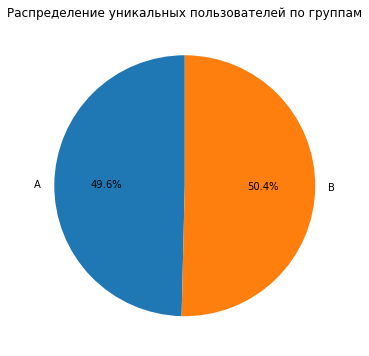

In [20]:

# построим круговую диаграмму для визуализауции соотношения групп А и В в тесте 'interface_eu_test'
plt.figure(figsize=(6,6))
plt.pie(
    interface_eu_test['user_id'], 
    labels=interface_eu_test['group'], 
    autopct='%1.1f%%', 
    startangle=90
)
plt.title('Распределение уникальных пользователей по группам')
plt.show()

Пользователи в тесте 'interface_eu_test' распределены практически равномерно, перечения в группах отсутствуют, выборки независимы.

**3\.2 Проанализируйте данные о пользовательской активности по таблице `ab_test_events`:**

- оставьте только события, связанные с участвующими в изучаемом тесте пользователями;

In [21]:
# выгрузим информацию о датафрейме
display(events.head(5))
events.info()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Датафрейм состоит из 4 столбцов и 787286 строк. Присутствуют пропуски в столбце 'details', который, предположительно, не потребуется для исследования, в связи с чем оставим данные как есть. 
В данных присутствует пользователей с id 'GLOBAL'. Посмотрим подробнее информацию об этом пользователе.

In [22]:
# создадим датафрейм с данными пользователя GLOBAL
user_GLOBAL = events[events['user_id'] == 'GLOBAL']
display(user_GLOBAL)

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
11,GLOBAL,2020-12-01 00:03:02,product_page,NaN
12,GLOBAL,2020-12-01 00:03:13,product_page,NaN
36,GLOBAL,2020-12-01 00:06:01,product_page,NaN
...,...,...,...,...
787263,GLOBAL,2020-12-31 23:53:42,purchase,4.49
787270,GLOBAL,2020-12-31 23:55:53,purchase,4.49
787271,GLOBAL,2020-12-31 23:56:17,purchase,4.49
787274,GLOBAL,2020-12-31 23:56:35,product_cart,NaN


In [23]:
# проверим наличие данных о регистрации этого пользователя
user_GLOBAL = user_GLOBAL[user_GLOBAL['event_name'] == 'registration']
display(user_GLOBAL)

,user_id,event_dt,event_name,details


В данных остутствуют сведения о регистраиции пользователя с id 'GLOBAL'. Возможно, это технический пользователь, данные о котором не должны учитываться при проведении дальнейшего анализа. 

In [24]:
# объединим датафреймы для получения совокупной информации о пользовательской активности
df=pd.merge(participants, events, on = 'user_id')
display(df.head(5))

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN


In [25]:
# оставим информацию о пользователях, принявших участие в А/В тестировании 'interface_eu_test'
df=df[df['ab_test']=='interface_eu_test']
display(df.head(5))
df.info()

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 73815 entries, 0 to 92757
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     73815 non-null  object        
 1   group       73815 non-null  object        
 2   ab_test     73815 non-null  object        
 3   device      73815 non-null  object        
 4   event_dt    73815 non-null  datetime64[ns]
 5   event_name  73815 non-null  object        
 6   details     19450 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 4.5+ MB


Датафрейм с пользователями А/Втестирования 'interface_eu_test' содержит 7 столбцов и 73815 строк. Типы данных определены корректно. 

In [26]:
# выведем уникальные событя для столбца 'event_name'
df['event_name'].unique()

array(['registration', 'login', 'product_page', 'product_cart',
       'purchase'], dtype=object)

Ошибки в названиях событий отсутстуют, можно проводить агрегации.

-----

- определите горизонт анализа: рассчитайте время (лайфтайм) совершения события пользователем после регистрации и оставьте только те события, которые были выполнены в течение первых семи дней с момента регистрации;

In [27]:
# найдем минимальную дату регистрации для каждого user_id
first_reg = df.loc[df['event_name'] == 'registration', ['user_id', 'event_dt']].groupby('user_id', as_index=False)['event_dt'].min()
first_reg = first_reg.rename(columns={'event_dt': 'registration_date'})

# объединим обратно с исходным df, чтобы у всех строк был столбец registration_date для соответствующего user_id
df = df.merge(first_reg, on='user_id', how='left')

display(df.head(5))

,user_id,group,ab_test,device,event_dt,event_name,details,registration_date
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31


Так как проведена фильтрация данных, где обязательным условием является факт регистрации пользователя, данные о пользователе с id 'GLOBAL' не попадут в выборку.

In [28]:
# создадим новый столбец, где рассчитано время (лайфтайм) совершения события пользователем после регистрации 
df['life_time']=(df['event_dt']-df['registration_date']).dt.days

In [29]:
# оставим в df данные о событиях, которые были выполнены в течение первых семи дней с момента регистрации 
# (день регистрации считаем первым днем)
df= df[df['life_time']<7]
display(df.head(5))
df.info()

,user_id,group,ab_test,device,event_dt,event_name,details,registration_date,life_time
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 63805 entries, 0 to 73814
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            63805 non-null  object        
 1   group              63805 non-null  object        
 2   ab_test            63805 non-null  object        
 3   device             63805 non-null  object        
 4   event_dt           63805 non-null  datetime64[ns]
 5   event_name         63805 non-null  object        
 6   details            16125 non-null  object        
 7   registration_date  63805 non-null  datetime64[ns]
 8   life_time          63805 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 4.9+ MB


Датафрейм содержит 9 столбцов и 63805 строк, типы данных указаны корректно.

-------

Оцените достаточность выборки для получения статистически значимых результатов A/B-теста. Заданные параметры:

- базовый показатель конверсии — 30%,

- мощность теста — 80%,

- mde - 3% (исходя из данных нулевой гипотезы)

- достоверность теста — 95%.

In [30]:
# для дальнейших расчетов приведем столбы 'event_dt' и 'registration_date' к формату даты без времени.
df['event_dt']=df['event_dt'].dt.date
df['registration_date']=df['registration_date'].dt.date

In [31]:
# рассчитаем необходимое количество пользовтелей проведения А/В тестирования по дананным параметрам
# зададим параметры 
alpha = 0.05  # уровень значимости
beta = 0.2  # ошибка второго рода, часто 1 - мощность
power = 0.8  # мощность теста
p = 0.3 # базовый уровень доли
mde = 0.03 # минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3761


In [32]:
# рассчитаем длительность для тестировани
# среднее количество пользователей приложения в день по историческим данным
avg_daily_users = ceil(
    df
    .groupby(['event_dt'])
    .agg({
        'user_id': 'nunique',
    })
    .mean()['user_id']
)

# рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(2*sample_size/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 1055 пользователей в день составит 8 дней


In [33]:
# посчитаем длительность тестирования
days_count=df['event_dt'].nunique()
print(f'Фактическое количество дней тестирования: {days_count}')

Фактическое количество дней тестирования: 23


------

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [34]:
# создадим датафрейм с общим количеством посетителей в разрезе по группам
df_all = (
    df.groupby(['group'])
      .agg({'user_id': 'nunique'})
      .rename(columns={'user_id': 'total_users'})
      .reset_index()
)

# создадим датафрейм с количеством посетителей, сделавших покупку, в разрезе по группам
df_purchase = (
    df.loc[df['event_name'] == 'purchase']
      .groupby(['group'])
      .agg({'user_id': 'nunique'})
      .rename(columns={'user_id': 'purchase_users'})
      .reset_index()
)

# объединим датафреймы
df_test_group = df_all.merge(df_purchase, on='group', how='left')
# посчитаем конверсию для каждой группы
df_test_group['conversion']= round(df_test_group['purchase_users']/df_test_group['total_users'],2)

display(df_test_group)

# разницу между долями (A - B). 
conversions = df_test_group.set_index('group')['conversion']  # объект Series с индексом по group
diff_BA = round((conversions.loc['B'] - conversions.loc['A']) * 100, 1)

print (f'Разница между долями конверсий для выборок B и A составила {diff_BA} пп')

,group,total_users,purchase_users,conversion
0,A,4952,1377,0.28
1,B,5011,1480,0.30


Разница между долями конверсий для выборок B и A составила 2.0 пп


Необходимый размер выборки для каждой группы для проведения теста составил 3761 пользователей. Количество пользователей в каждой группе достаточно для проведения тестирования. Длительность теста в 23 дня (при минимальном сроке 8 дней) является достаточной для получения результатов и принятия решения.

Дополнительно на основании данных столбца 'details' исследуем изменения в стоимости регистрации и среднем чеке (возможные прокси-метрики для тестирования).

In [35]:
# приведем данные к числовому типу
df['details'] = pd.to_numeric(df['details'], errors='coerce')

In [36]:
# посчитаем стоимость регистрации
df_registration_cost = (
    df.loc[df['event_name'] == 'registration']
      .groupby(['group'])
      .agg({'details': 'mean'})
      .rename(columns={'details': 'redistration_cost'})
      .reset_index()
)
display(df_registration_cost)

,group,redistration_cost
0,A,-2.046266
1,B,-2.091740


Стоимость регистрации является отрицательной для обеих тестовых групп.

In [37]:
# посчитаем средний чек и количество покупок
df_purchase_mean = (
    df.loc[df['event_name'] == 'purchase']
      .groupby(['group'])
      .agg({'user_id':'count'
          , 'details': 'sum'})
      .rename(columns={'details': 'purchase_sum', 'user_id' : 'purchase_count'})
      .reset_index()
)
df_purchase_mean['avg_purchase']=df_purchase_mean['purchase_sum']/df_purchase_mean['purchase_count']

display(df_purchase_mean)

,group,purchase_count,purchase_sum,avg_purchase
0,A,2700,75579.40,27.992370
1,B,3462,82545.28,23.843235


Совокупное количество покупок в тестовой группе значительно выше, при этом средний чек ниже. 

-------

- сделайте предварительный общий вывод об изменении пользовательской активности в тестовой группе по сравнению с контрольной.

По предварительным данным конверсия в тстовой группе по сравнению с контрольной по истечении 23 дней тестирования выросла на 2 пп. Следует учитывать, что запланированный рост был 3пп.
Стоимость регистрации является отрицательной для обеих тестовых групп.
Совокупное количество покупок в тестовой группе значительно выше, при этом средний чек ниже. 

## Проведите оценку результатов A/B-тестирования:

**Сформулируем гипотезы**

Н0: упрощение интерфейса не окажет влияния на конверсию зарешистированных поотзователей в течение семи дней после регистрации

Н1: упрощение интерфейса приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится.

Для проверки будем использовать z-test пропорций, который позволяет определить, существует ли значимая разница между долями в двух независимых выборках.

In [38]:
# проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок

n_a = df_test_group.loc[df_test_group.group == 'A', 'total_users'].sum()
n_b = df_test_group.loc[df_test_group.group == 'B', 'total_users'].sum()

m_a = df_test_group.loc[df_test_group.group == 'A', 'purchase_users'].sum()
m_b = df_test_group.loc[df_test_group.group == 'B', 'purchase_users'].sum()
p_a, p_b = m_a/n_a, m_b/n_b # рассчитываем доли успехов для каждой группы: A и B

print(f'n_a={n_a}, n_b={n_b}')

print(f'm_a={m_a}, m_b={m_b}')

print(f'p_a={p_a}, p_b={p_b}')

if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется')

n_a=4952, n_b=5011
m_a=1377, m_b=1480
p_a=0.27806946688206785, p_b=0.29535022949511075
Предпосылка о достаточном количестве данных выполняется


In [39]:
# проведем Z-тест пропорций
alpha = 0.05 
diff = p_b - p_a
threshold = 0.03
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)
p_value_ztest

if (p_value_ztest > alpha) :
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения')

pvalue=0.028262547212292124 < 0.05
Нулевая гипотеза не находит подтверждения


- Опишите выводы по проведённой оценке результатов A/B-тестирования. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

------
**Выводы:**

По результатам z-test пропорций установлено, изменение интерфейса привело к росту конверсии, различие является статистически значимым.

При этом по истечении 23 дней тестирования ожидаемый эффект (рост на 3 процентных пункта) не был достигнут - конверсия выросла на 2 процентных пункта. 

Следует также отметить, что совокупное количество покупок в тестовой группе значительно выше, при этом средний чек ниже.

Полагаю, что, так как внедрение нового интерфейса в группе В привело к увеличению количества продаж (что было одной из целей изменений), новая фича должна быть внедрена для всех пользователей. Для увеличения уровня конверсии до желаемого необходимо проведение маркетирговых активностей, стимулирующих новых пользователей покупать в течении 7 дней после регистрации. Дополнительно можно сравнить конверсии по когортам (например, в течении 2х недель/ 30 дней после регистрации), чтобы проанализировать поведение пользователей. 